In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unrar x "/content/drive/My Drive/BUSI_segreg_balanced.rar" "drive/My Drive"

In [ ]:
#DATA

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

In [ ]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "/content/drive/My Drive/BUSI_segreg_balanced/all orig/*")))
    masks = sorted(glob(os.path.join(path, "/content/drive/My Drive/BUSI_segreg_balanced/all masks/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
def read_image(path):
     path = path.decode()
     x = cv2.imread(path, cv2.IMREAD_COLOR)
     x = cv2.resize(x, (256, 256))
     x = x/255.0
     return x

In [ ]:
def read_mask(path):
     path = path.decode()
     x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
     x = cv2.resize(x, (256, 256))
     x = x/255.0
     x = np.expand_dims(x, axis=-1)
     return x

In [ ]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([256, 256, 3])
    y.set_shape([256, 256, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [ ]:
#MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [ ]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [ ]:
def build_model():
    size = 256
    num_filters = [16, 32, 48, 64]
    inputs = Input((size, size, 3))

    skip_x = []
    x = inputs

    ## Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    ## Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()

    ## Decoder
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    ## Output
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x)

In [ ]:
#TRAIN

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard

In [ ]:
def iou(y_true, y_pred):
     def f(y_true, y_pred):
         intersection = (y_true * y_pred).sum()
         union = y_true.sum() + y_pred.sum() - intersection
         x = (intersection + 1e-15) / (union + 1e-15)
         x = x.astype(np.float32)
         return x
         
     return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [ ]:
if __name__ == "__main__":
     ## Dataset
     path = "/content/drive/My Drive/BUSI_segreg_balanced/"
     (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)

In [ ]:
# loss="binary_crossentropy"

# learning_rates = [1e-4, 1e-3, 1e-6, 1e-5]
# diff_num_filters = [[16, 32, 48, 64], [16, 32, 48]]
# batches = [8, 16, 32, 4]
# diff_epochs = [50, 100, 125]
# size = 256

# best_hparams = None
# best_loss = sys.maxsize

# for lr in learning_rates:
#   for num_filters in diff_num_filters:
#     for batch in batches:
#       for epochs in diff_epochs:
#         (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
#         train_dataset = tf_dataset(train_x, train_y, batch=batch)
#         valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)
#         train_steps = len(train_x)//batch
#         valid_steps = len(valid_x)//batch

#         if len(train_x) % batch != 0:
#             train_steps += 1
#         if len(valid_x) % batch != 0:
#             valid_steps += 1


#         identyfikator=str(time.time())
#         print(identyfikator)
#         print(f"lr={lr}, num_filters={num_filters}, batch={batch}, epochs={epochs}, size={size}")

#         model=build_and_compile(size, num_filters, lr, loss)
        

#         callbacks = [
#               ModelCheckpoint(f"/content/drive/My Drive/BUSI_segreg_balanced/files/model-{identyfikator}.h5"),
#               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
#               CSVLogger(f"/content/drive/My Drive/BUSI_segreg_balanced/files/data-{identyfikator}.csv"),
#               TensorBoard(),
#               EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#         ]

#         history=train(batch, train_x, valid_x, train_dataset, valid_dataset, model, epochs, callbacks)
#         with open(f'/content/drive/My Drive/BUSI_segreg_balanced/hist/hist-{identyfikator}', 'wb') as file_pi:
#           pickle.dump(history.history, file_pi)
#         val_loss=min(history.history['val_loss'])
#         if best_hparams is None or val_loss < best_loss:
#             best_hparams = (lr, num_filters, batch,  epochs, size)
#             best_loss = val_loss
#         print(f"validation loss: {val_loss} for lr={lr}, num_filters={num_filters}, batch={batch}, epochs={epochs}, size={size}")
#         print(f"best hparams: {best_hparams}")

# print(f"best hparams: {best_hparams}")

In [ ]:
## Hyperparameters


# najlepsza architektura wyłoniona z 'hyperparameters tuning':
# validation loss for lr=1e-3, num_filters=[16, 32, 48, 64], batch=8, epochs=125, size=256

batch = 8
lr = 1e-3
epochs = 125

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

In [ ]:
model = build_model()
opt = tf.keras.optimizers.Adam(lr)
metrics = ["acc", tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), iou]
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)

In [ ]:
callbacks = [
          ModelCheckpoint("/content/drive/My Drive/BUSI_segreg_balanced/files_best_archi/model.h5"),
          ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
          CSVLogger("/content/drive/My Drive/BUSI_segreg_balanced/files_best_archi/data.csv"),
          TensorBoard(),
          EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
     ]

In [ ]:
train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch

if len(train_x) % batch != 0:
    train_steps += 1
if len(valid_x) % batch != 0:
    valid_steps += 1

history = model.fit(train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks)

Epoch 1/125
41/41 [==============================] - 13s 193ms/step - loss: 0.3623 - acc: 0.9132 - recall: 0.1303 - precision: 0.2719 - iou: 0.0765 - val_loss: 0.4758 - val_acc: 0.9424 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.0517
Epoch 2/125
41/41 [==============================] - 6s 154ms/step - loss: 0.2245 - acc: 0.9402 - recall: 0.3437 - precision: 0.6230 - iou: 0.1372 - val_loss: 0.3582 - val_acc: 0.9128 - val_recall: 0.2258 - val_precision: 0.2346 - val_iou: 0.0761
Epoch 3/125
41/41 [==============================] - 6s 154ms/step - loss: 0.1954 - acc: 0.9417 - recall: 0.3380 - precision: 0.6534 - iou: 0.1628 - val_loss: 1.0811 - val_acc: 0.7161 - val_recall: 0.4258 - val_precision: 0.0892 - val_iou: 0.0714
Epoch 4/125
41/41 [==============================] - 6s 153ms/step - loss: 0.1733 - acc: 0.9462 - recall: 0.4023 - precision: 0.6892 - iou: 0.1967 - val_loss: 0.6650 - val_acc: 0.6853 - val_recall: 0.8587 - val_precision: 0.1394 - val_iou: 0.1124
Epo

In [ ]:
#PREDICT

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from tqdm import tqdm

In [ ]:
def read_image(path):
     x = cv2.imread(path, cv2.IMREAD_COLOR)
     x = cv2.resize(x, (256, 256))
     x = x/255.0
     return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = np.expand_dims(x, axis=-1)
    return x

In [ ]:
def mask_parse(mask):
     mask = np.squeeze(mask)
     mask = [mask, mask, mask]
     mask = np.transpose(mask, (1, 2, 0))
     return mask

In [ ]:
if __name__ == "__main__":
     ## Dataset
     path = "/content/drive/My Drive/BUSI_segreg_balanced/"
     batch_size = 8
     (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)

In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

test_steps = (len(test_x)//batch_size)
if len(test_x) % batch_size != 0:
    test_steps += 1

In [ ]:
# # Evaluate the model on the test data using `evaluate`
# print("Evaluate on test data")
# results = model.evaluate(test_x, test_y, batch_size=8)
# print("test loss, test acc:", results)

# # Generate predictions (probabilities -- the output of the last layer)
# # on new data using `predict`
# print("Generate predictions for 3 samples")
# predictions = model.predict(test_x[:3])
# print("predictions shape:", predictions.shape)

In [ ]:
# model.evaluate(test_dataset, steps=test_steps)
# # model.evaluate(test_dataset, batch_size=8)

In [ ]:
with CustomObjectScope({'iou': iou}):
    model = tf.keras.models.load_model("/content/drive/My Drive/BUSI_segreg_balanced/files/model.h5")

In [ ]:
for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
          x = read_image(x)
          y = read_mask(y)
          y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
          h, w, _ = x.shape
          white_line = np.ones((h, 10, 3)) * 255.0
          all_images = [
            x * 255.0, white_line,
            mask_parse(y), white_line,
            mask_parse(y_pred) * 255.0
          ]
          image = np.concatenate(all_images, axis=1)
          cv2.imwrite(f"/content/drive/My Drive/BUSI_segreg_balanced/results_best_archi/{i}.png", image)

100%|██████████| 39/39 [00:03<00:00, 12.83it/s]


In [ ]:
#https://www.kaggle.com/rajaatif/mias-mammogram

import matplotlib.pyplot as plt

def hist(history):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].legend(['Training loss', 'Validation Loss'],fontsize=18)
    ax[0].set_xlabel('Epochs ',fontsize=16)
    ax[0].set_ylabel('Loss',fontsize=16)
    ax[0].set_title('Training loss x Validation Loss',fontsize=16)
 
 
    ax[1].plot(history.history['acc'])
    ax[1].plot(history.history['val_acc'])
    ax[1].legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    ax[1].set_xlabel('Epochs ',fontsize=16)
    ax[1].set_ylabel('Accuracy',fontsize=16)
    ax[1].set_title('Training Accuracy x Validation Accuracy',fontsize=16)

    ax[2].plot(history.history['iou'])
    ax[2].plot(history.history['val_iou'])
    ax[2].legend(['IOU', 'Validation IOU'],fontsize=18)
    ax[2].set_xlabel('Epochs ',fontsize=16)
    ax[2].set_ylabel('Accuracy',fontsize=16)
    ax[2].set_title('IOU x Validation IOU',fontsize=16)
    
def plot_any(arr, title = ''):
    plt.figure(figsize = (15, 25))
    for i in range(len(arr)):
        plt.subplot(1,len(arr),i + 1)
        plt.title(title)
        plt.imshow(arr[i], cmap = 'gray');

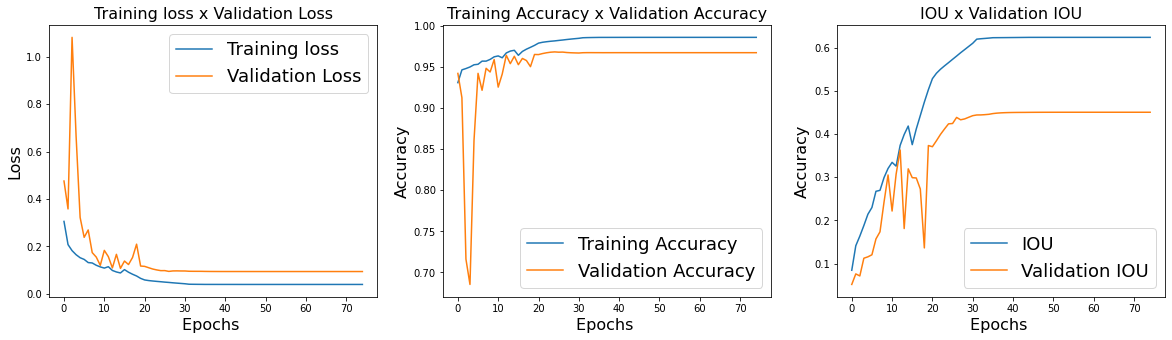

In [ ]:
hist(history)

In [ ]:
#Szumy na zbiorze walidacyjnym można zmniejszyć, przydzielając większą część datasetu do valid_dateset. (Częstym problemem medycznych datasetów jest ich niewielka objętość.) 
#Split danych: 60:20:20

In [ ]:
#credits
#https://github.com/nikhilroxtomar/Polyp-Segmentation-using-UNET-in-TensorFlow-2.0